# **Section:** Feature importance

In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [3]:
%%time

path = "_data/full_scaled.pkl.bz2"


train_datas = {}

sample = pd.read_pickle(path)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = sample

del sample

CPU times: user 9min 32s, sys: 4min 42s, total: 14min 14s
Wall time: 1min 59s


In [4]:
%%time

path = "_data/full.pkl.bz2"

full = pd.read_pickle(path)

full[X_columns] =  full[X_columns].astype(np.float32)

CPU times: user 2min 5s, sys: 3.8 s, total: 2min 8s
Wall time: 1min 16s


## Run the classifiers with the selected parameters

In [5]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [6]:
TEST_SIZE = 0.30

def train_and_run(data, random_state):
    X_train, X_test, y_train, y_test = train_test_split(
        data[X_columns], data.cls, 
        test_size=TEST_SIZE, random_state=random_state)

    clf = RandomForestClassifier(n_jobs=-1, **RF_PARAMS)

    clf.fit(X_train.values, y_train.values)

    predictions = clf.predict(X_test.values)
    probabilities = clf.predict_proba(X_test.values)

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "clf_name": "RF",
        "test_name": str(TEST_SIZE),
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        "train_idx": X_train.index,
        "test_idx": X_test.index,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})    
    return result
    

In [7]:
%%time
results = train_and_run(data, 42)

CPU times: user 4h 23min 58s, sys: 2h 3min 19s, total: 6h 27min 17s
Wall time: 8min 28s


In [8]:
joblib.dump(results, "_cache/feat_importance.pkl.bz2", compress=3)

['_cache/feat_importance.pkl.bz2']

In [27]:
prec, recs, thrs = results.prec_rec_curve

In [28]:
idx = nearest(rec, .9)
thr = thrs[idx]
thr, prec[idx], recs[idx]

(0.0020000000000000018, 0.009823872008981827, 0.9150326797385621)

In [11]:
predictions = (results.probabilities[:,1] >= thr).astype(int)

In [12]:
df = pd.DataFrame({"cls": results.real_cls, "predictions": predictions})
df = df[df.cls == 1]
df["FP"] = (df.cls != df.predictions).astype(int)

In [13]:
df.describe()

,cls,predictions,FP
count,459.0,459.000000,459.000000
mean,1.0,0.882353,0.117647
std,0.0,0.322541,0.322541
min,1.0,0.000000,0.000000
25%,1.0,1.000000,0.000000
50%,1.0,1.000000,0.000000
75%,1.0,1.000000,0.000000
max,1.0,1.000000,1.000000


## ponemos estas nuevas clases

In [14]:
len(results.train_idx), len(results.test_idx), len(data)

(1770978, 758991, 2529969)

In [15]:
# retiramos las observaciones que se usaron para testear
test_data = data[data.index.isin(results.test_idx)].copy()

In [16]:
# como test data tiene un orden acendente
# ponemos test_idx en el mismo order
order = np.argsort(results.test_idx)

# asignamos las predicciones en el mismo orden
test_data["predictions"] = predictions[order]

# nos quedamos solo con las clases positivas
rr = test_data[test_data.cls == 1].copy()

# cambiamos "predictions" en FP y FN

def to_tpfn(row):
    return "TP" if row.predictions else "FN"
    

rr["clf_as"] = rr.apply(to_tpfn, axis=1)

In [31]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, **RF_PARAMS)

In [32]:
clf.fit(rr[X_columns].values, rr.predictions.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [19]:
fimp = pd.DataFrame({"Feature": X_columns, "Importance": clf.feature_importances_})
fimp = fimp.sort_values("Importance").reset_index()
fimp.tail()

,index,Feature,Importance
57,61,ppmb,0.033025
58,42,Psi_CS,0.036328
59,40,PeriodLS,0.058264
60,43,Psi_eta,0.082601
61,41,Period_fit,0.094517


In [20]:
from matplotlib.cbook import boxplot_stats    

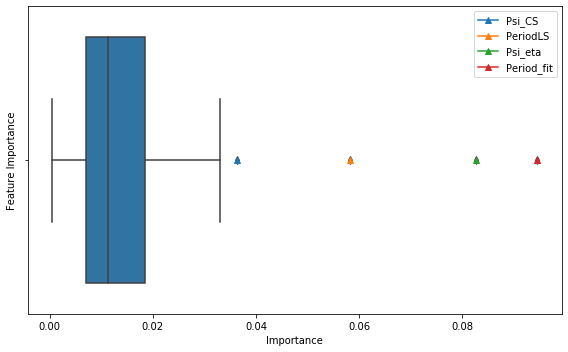

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

outliers = boxplot_stats(fimp.Importance)[0]["fliers"]
feat_outs = []

sns.boxplot(fimp.Importance, ax=ax)
for flier in outliers:
    feat = fimp[fimp.Importance == flier].Feature.values[0]
    feat_outs.append(feat)
    ax.plot([flier], [0], marker='^', label=feat)

ax.set_ylabel("Feature Importance")
ax.legend()

fig.tight_layout()

In [127]:
def get_clf_as(sid):
    return rr[rr.id == sid].clf_as.values[0]

real_rr = full[full.id.isin(rr.id)].copy()
real_rr["clf_as"] = real_rr.id.apply(get_clf_as)
real_rr = real_rr[["id", "cls", "clf_as", "vs_type"] + feat_outs]
real_rr

,id,cls,clf_as,vs_type,Psi_CS,PeriodLS,Psi_eta,Period_fit
5994,32340000017286,1,FN,RRLyr-RRab,0.188947,0.172709,2.101878,1.000000e+00
14929,32340000042102,1,TP,RRLyr-RRab,0.212557,0.477552,0.237338,1.621282e-06
22290,32340000061549,1,TP,RRLyr-RRab,0.198176,0.430800,1.043776,2.635792e-03
25219,32340000069692,1,TP,RRLyr-RRab,0.248541,0.522949,0.485304,2.577471e-08
35486,32340000098773,1,TP,RRLyr-RRab,0.171968,0.573265,1.114321,0.000000e+00
...,...,...,...,...,...,...,...,...
2500675,32610000812840,1,TP,RRLyr-RRab,0.288369,0.473197,0.788822,0.000000e+00
2510005,32610000827013,1,TP,RRLyr-RRab,0.266721,0.504582,0.285871,0.000000e+00
2519558,32610000840894,1,TP,RRLyr-RRc,0.205312,0.314699,0.792071,0.000000e+00
2523069,32610000846013,1,TP,RRLyr-RRab,0.258422,0.534404,0.341349,0.000000e+00


In [123]:
outlimit = min(boxplot_stats(real_rr.PeriodLS.values)[0]['fliers'])
outlimit

0.99209315

In [141]:
real_rr = real_rr[real_rr.PeriodLS.between(0, outlimit)]

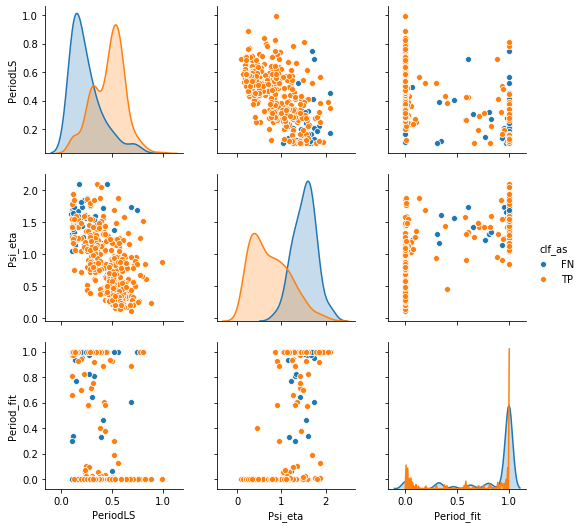

In [142]:
sns.pairplot(
    real_rr, 
    hue="clf_as", 
    vars=feat_outs[-3:], 
    diag_kind="kde")

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


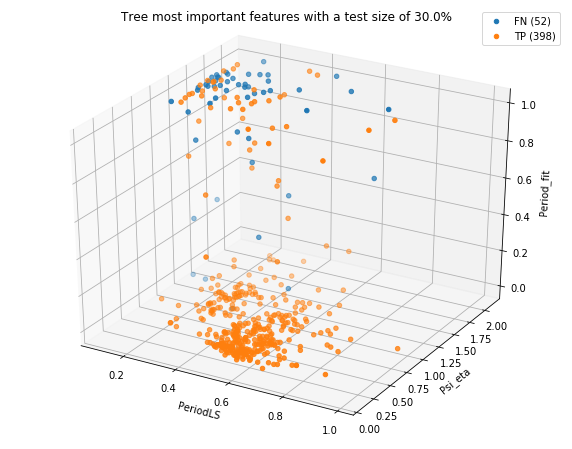

In [143]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

fn = real_rr[rr.clf_as == "FN"]
params = [fn[k].values for k in feat_outs[-3:]]
ax.scatter(*params, label=f"FN ({len(fn)})")

tp = real_rr[rr.clf_as == "TP"]
params = [tp[k].values for k in feat_outs[-3:]]
ax.scatter(*params, label=f"TP ({len(tp)})")

ax.set_xlabel(feat_outs[-3])
ax.set_ylabel(feat_outs[-2])
ax.set_zlabel(feat_outs[-1])

ax.set_title(f"Tree most important features with a test size of {TEST_SIZE * 100}%\n")

ax.legend();

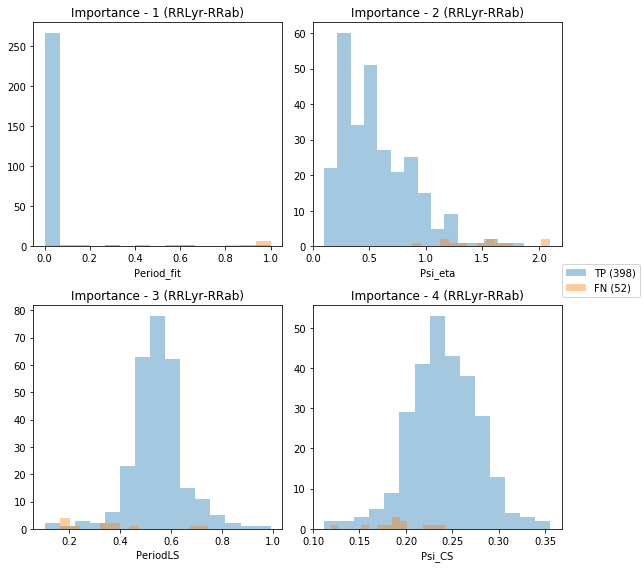

In [149]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(8, 8))

bins=15; vs_type="RRLyr-RRab"
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"TP ({len(tp)})", f"FN ({len(fn)})") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(tp[tp.vs_type==vs_type][oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(fn[fn.vs_type==vs_type][oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1} ({vs_type})")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

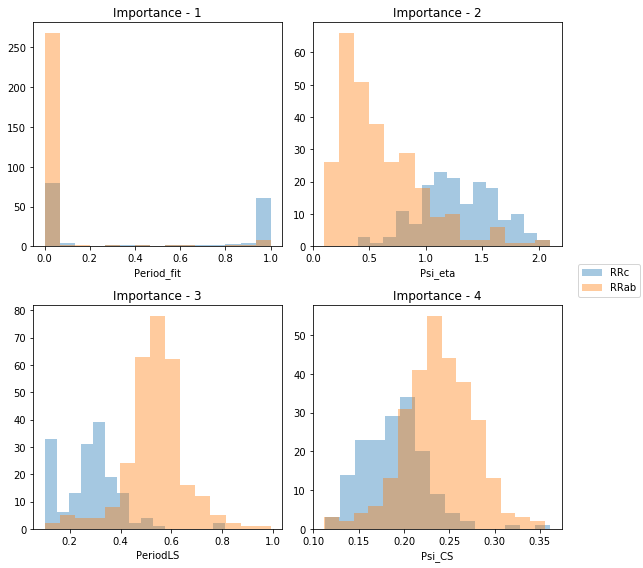

In [145]:
fig, axes = plt.subplots(2, int(len(feat_outs)/2), figsize=(8, 8))

bins=15
for idx, oname, ax in zip(range(len(feat_outs)), feat_outs[::-1], it.chain(*axes)):    
    tp_label, fn_label = (
        (f"RRc", f"RRab") 
        if idx == 0 
        else ("__nolegend__", "__nolegend__"))
    sns.distplot(real_rr[real_rr.vs_type == "RRLyr-RRc"][oname], ax=ax, label=tp_label, bins=bins, kde=False, norm_hist=False)
    sns.distplot(real_rr[real_rr.vs_type != "RRLyr-RRc"][oname], ax=ax, label=fn_label, bins=bins, kde=False, norm_hist=False)
    ax.set_title(f"Importance - {idx+1}")
    
fig.legend(loc=7, bbox_to_anchor=(1.12, 0.5))
fig.tight_layout()

In [116]:
Counter(rr[rr.clf_as=="TP"].vs_type)

Counter({'RRLyr-RRab': 277, 'RRLyr-RRc': 128})